# Proyecto Integrador - Módulo 2: Predicción de Popularidad de Noticias Online

## A. Introducción

### 1. Origen del Dataset
El conjunto de datos utilizado es **"Online News Popularity"**, proveniente del **UCI Machine Learning Repository**. Fue donado originalmente por investigadores de la Universidad de Beira Interior (Portugal). Contiene métricas de artículos publicados por **Mashable** durante un periodo de dos años.

- **Fuente**: [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/332/online+news+popularity)
- **Registros**: 39,797 artículos.
- **Atributos**: 61 variables (58 predictivas, 2 no predictivas, 1 objetivo).

### 2. Definición del Problema
El objetivo es predecir la **popularidad** de un artículo de noticias antes de su publicación (o poco después), medida a través del número de veces que ha sido compartido en redes sociales (**`shares`**).
Predecir la viralidad es crucial para editores y creadores de contenido para optimizar sus estrategias de publicación y maximizar el alcance.

### 3. Justificación de la Técnica
Se utilizará **Regresión** ya que la variable objetivo, `shares`, es **cuantitativa y continua** (número entero de veces compartido). No se trata de clasificar si es "popular o no", sino de estimar una magnitud específica. 
Para ello, aplicaremos y compararemos múltiples modelos lineales (**Regresión Lineal**, **Lasso**, **Ridge**, **ElasticNet**) para entender qué características (palabras clave, longitud, sentimiento, fecha) influyen más en la viralidad.

---

## B. Análisis Exploratorio de Datos (EDA) y Procesamiento

### 1. Carga de Datos y Limpieza Inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar dataset
try:
    df = pd.read_csv('Data/OnlineNewsPopularity.csv')
    print("Dataset cargado correctamente.")
except FileNotFoundError:
    # Fallback si se corre desde otro directorio
    import os
    if os.path.exists('OnlineNewsPopularity/Data/OnlineNewsPopularity.csv'):
        df = pd.read_csv('OnlineNewsPopularity/Data/OnlineNewsPopularity.csv')
        print("Dataset cargado correctamente (ruta alternativa).")
    else:
        print("Error: No se encuentra el archivo csv.")

# Verificación inicial
print(f"Dimensiones: {df.shape}")
df.head()

Dataset cargado correctamente.
Dimensiones: (39644, 61)


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [2]:
# Limpieza de nombres de columnas (tienen espacios vacíos al inicio)
df.columns = df.columns.str.strip()
print("Columnas limpias:", df.columns.tolist()[:5])

Columnas limpias: ['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens']


In [3]:
# Eliminar columnas no predictivas
# 'url': Identificador único, no sirve para predecir modelo general (pero útil para análisis de texto luego)
# 'timedelta': Días desde publicación, variable temporal del dataset, no del artículo
# MANTENEMOS URL TEMPORALMENTE para el análisis de texto posteror
df_clean = df.drop(['timedelta'], axis=1)
print(f"Dimensiones post-limpieza: {df_clean.shape}")

Dimensiones post-limpieza: (39644, 60)


### 2. Análisis Univariado (Variable Objetivo: `shares`)

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


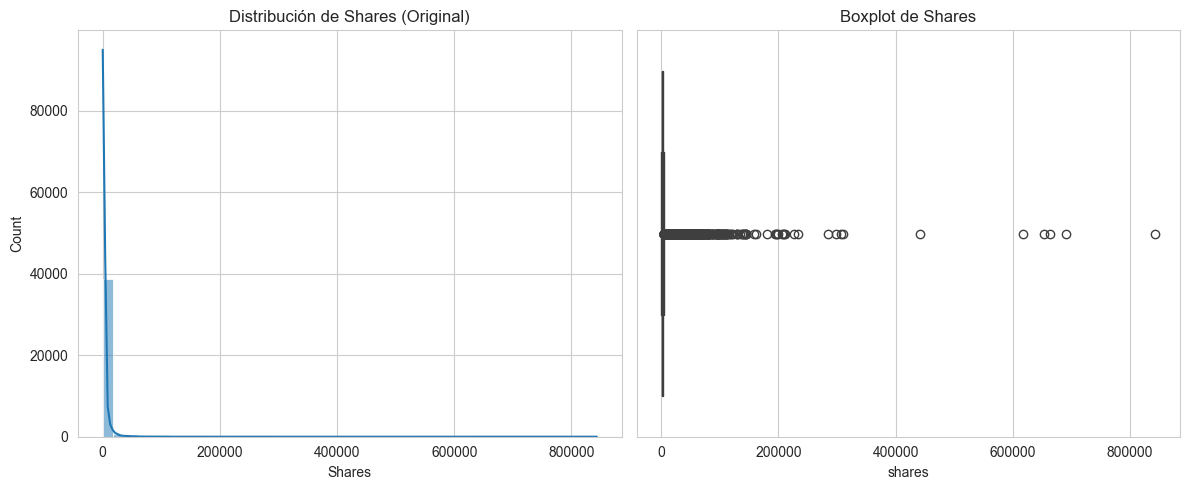

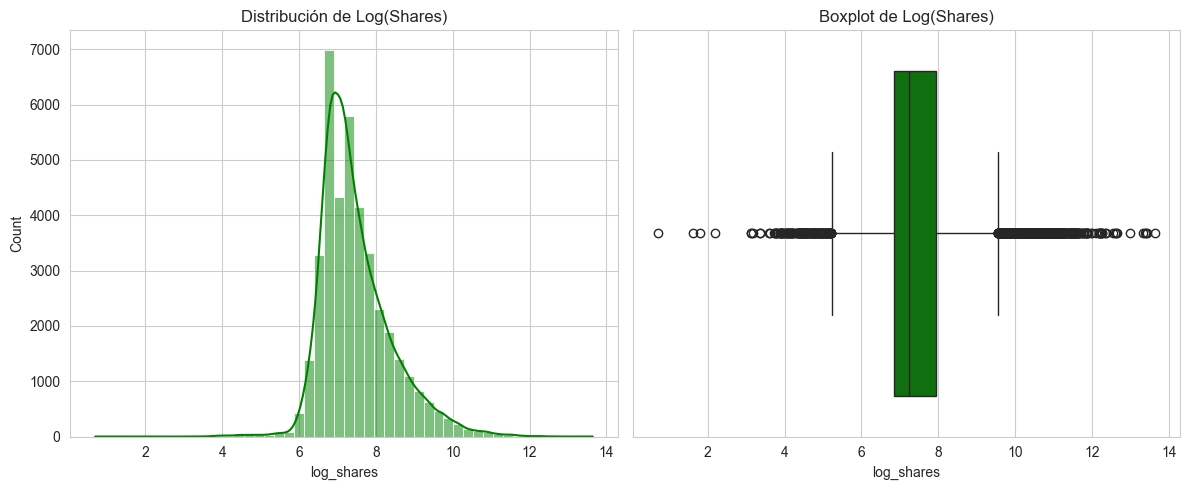

In [4]:
# Estadísticas descriptivas de la variable objetivo
print(df_clean['shares'].describe())

plt.figure(figsize=(12, 5))

# Histograma original
plt.subplot(1, 2, 1)
sns.histplot(df_clean['shares'], bins=50, kde=True)
plt.title('Distribución de Shares (Original)')
plt.xlabel('Shares')

# Boxplot para ver outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean['shares'])
plt.title('Boxplot de Shares')

plt.tight_layout()
plt.show()

# Transformación Logarítmica (para corregir el sesgo)
# Usamos log1p para evitar problemas con 0, aunque shares > 0 generalmente
df_clean['log_shares'] = np.log1p(df_clean['shares'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['log_shares'], bins=50, kde=True, color='green')
plt.title('Distribución de Log(Shares)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean['log_shares'], color='green')
plt.title('Boxplot de Log(Shares)')

plt.tight_layout()
plt.show()

### 3. Análisis Bivariado y Multivariado

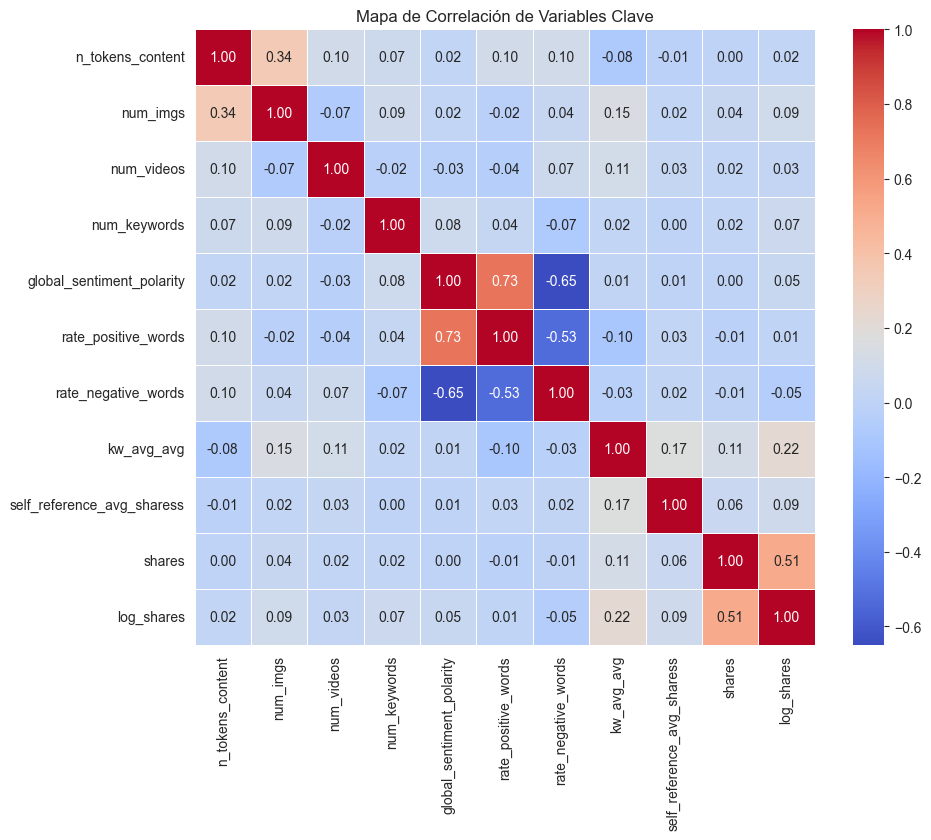

In [5]:
# Correlación: Seleccionamos variables numéricas clave para no saturar el mapa
# Variables de contenido: n_tokens_content, num_imgs, num_videos, num_keywords
# Variables de sentimiento: global_sentiment_polarity, global_rate_positive_words
# Target: shares

cols_corr = ['n_tokens_content', 'num_imgs', 'num_videos', 'num_keywords', 
             'global_sentiment_polarity', 'rate_positive_words', 'rate_negative_words', 
             'kw_avg_avg', 'self_reference_avg_sharess', 'shares', 'log_shares']

corr_matrix = df_clean[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Correlación de Variables Clave')
plt.show()

### Correlación con la Variable Objetivo (Bar Chart)
A continuación, visualizamos explícitamente cómo se correlaciona cada variable numérica con el **Log de Shares**. 
Esto permite identificar rápidamente qué características tienen mayor impacto positivo o negativo.

C:\Users\josea\AppData\Local\Temp\ipykernel_15668\58308423.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')


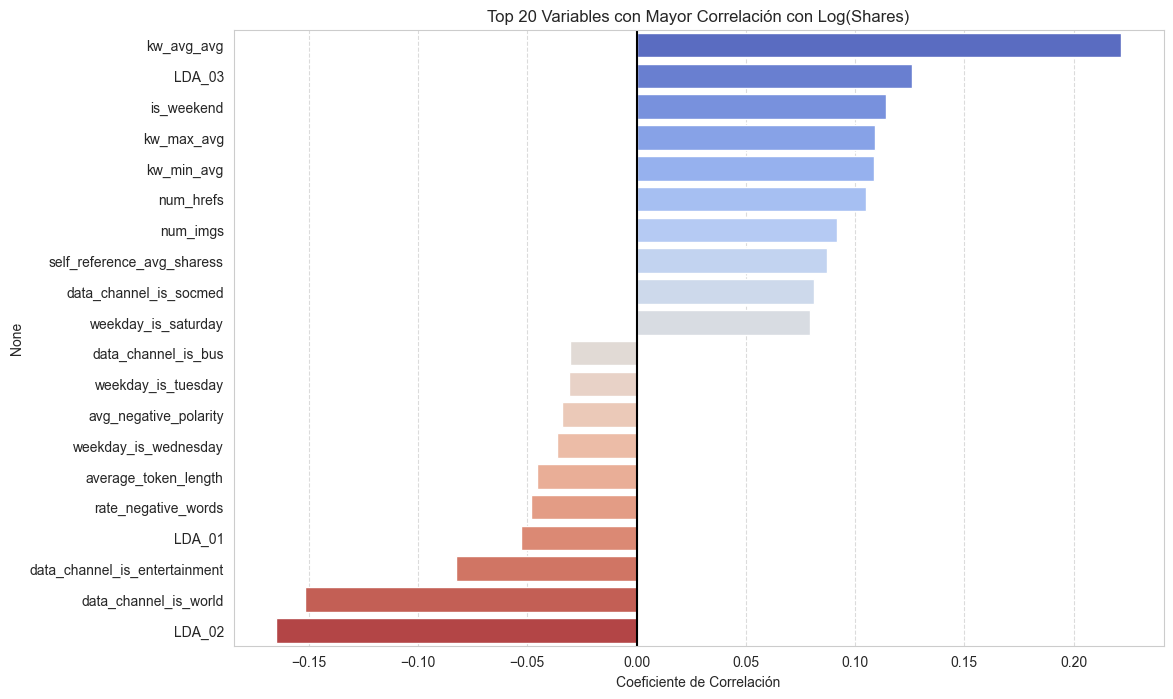

In [6]:
# Calcular correlación de todas las variables con log_shares
correlations = df_clean.select_dtypes(include=[np.number]).corrwith(df_clean['log_shares']).sort_values(ascending=False)

# Excluir la propia variable objetivo y 'shares' original
correlations = correlations.drop(['log_shares', 'shares'], errors='ignore')

# Seleccionar las 10 más positivas y 10 más negativas
top_positive = correlations.head(10)
top_negative = correlations.tail(10)
top_corr = pd.concat([top_positive, top_negative])

plt.figure(figsize=(12, 8))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title('Top 20 Variables con Mayor Correlación con Log(Shares)')
plt.xlabel('Coeficiente de Correlación')
plt.axvline(x=0, color='black', linestyle='-')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

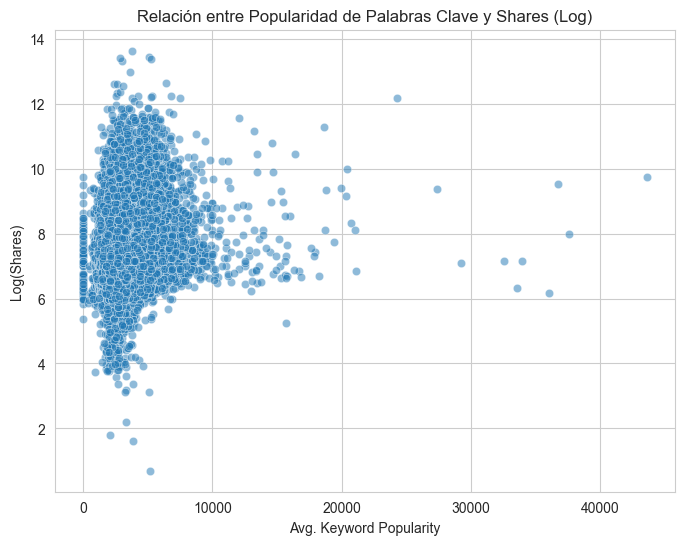

In [7]:
# Scatter plot: Palabras clave vs Shares
plt.figure(figsize=(8, 6))
sns.scatterplot(x='kw_avg_avg', y='log_shares', data=df_clean, alpha=0.5)
plt.title('Relación entre Popularidad de Palabras Clave y Shares (Log)')
plt.xlabel('Avg. Keyword Popularity')
plt.ylabel('Log(Shares)')
plt.show()

### 4. Procesamiento de Datos (Pre-Modelado)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Definir X e y
# Eliminamos URL ahora sí para el modelado numérico
X = df_clean.drop(['shares', 'log_shares', 'url'], axis=1)
y = df_clean['log_shares']

# 2. Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Escalado (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Datos de entrenamiento: {X_train_scaled.shape}")
print(f"Datos de prueba: {X_test_scaled.shape}")

Datos de entrenamiento: (31715, 58)
Datos de prueba: (7929, 58)


---

## C. Modelado

Implementaremos 4 modelos de regresión lineal:
1. **Linear Regression**: Modelo base sin regularización.
2. **Lasso (L1)**: Regularización L1, útil para selección de características (vuelve coeficientes a 0).
3. **Ridge (L2)**: Regularización L2, útil para multicolinealidad (reduce coeficientes pero no a 0).
4. **ElasticNet**: Combinación de L1 y L2.

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Diccionario para guardar resultados
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, is_log_target=True):
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Invertir log si es necesario
    if is_log_target:
        y_train_orig = np.expm1(y_train)
        y_test_orig = np.expm1(y_test)
        y_pred_train_orig = np.expm1(y_pred_train)
        y_pred_test_orig = np.expm1(y_pred_test)
    else:
        y_train_orig = y_train
        y_test_orig = y_test
        y_pred_train_orig = y_pred_train
        y_pred_test_orig = y_pred_test
        
    # Métricas Train
    rmse_train = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    mae_train = mean_absolute_error(y_train_orig, y_pred_train_orig)
    r2_train = r2_score(y_train_orig, y_pred_train_orig)
    
    # Métricas Test
    rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
    mae_test = mean_absolute_error(y_test_orig, y_pred_test_orig)
    r2_test = r2_score(y_test_orig, y_pred_test_orig)
    
    print(f"--- {name} ---")
    print(f"Train -> RMSE: {rmse_train:.2f}, R2: {r2_train:.4f}")
    print(f"Test  -> RMSE: {rmse_test:.2f}, R2: {r2_test:.4f}")
    print("")
    
    return {
        'Train_RMSE': rmse_train, 'Test_RMSE': rmse_test,
        'Train_MAE': mae_train, 'Test_MAE': mae_test,
        'Train_R2': r2_train, 'Test_R2': r2_test
    }

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
results['Linear Regression'] = evaluate_model('Linear Regression', lr, X_train_scaled, y_train, X_test_scaled, y_test)

# 2. Lasso (L1)
# alpha controla la fuerza de regularización
lasso = Lasso(alpha=0.001, random_state=42) # Alpha pequeño para no tumbar coeficientes importantes
lasso.fit(X_train_scaled, y_train)
results['Lasso'] = evaluate_model('Lasso', lasso, X_train_scaled, y_train, X_test_scaled, y_test)

# 3. Ridge (L2)
ridge = Ridge(alpha=10.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
results['Ridge'] = evaluate_model('Ridge', ridge, X_train_scaled, y_train, X_test_scaled, y_test)

# 4. ElasticNet
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42)
elastic.fit(X_train_scaled, y_train)
results['ElasticNet'] = evaluate_model('ElasticNet', elastic, X_train_scaled, y_train, X_test_scaled, y_test)

--- Linear Regression ---
Train -> RMSE: 11900.11, R2: -0.0202
Test  -> RMSE: 11000.69, R2: -0.0028

--- Lasso ---
Train -> RMSE: 11885.08, R2: -0.0176
Test  -> RMSE: 11003.06, R2: -0.0033

--- Ridge ---
Train -> RMSE: 11898.21, R2: -0.0199
Test  -> RMSE: 11000.91, R2: -0.0029

--- ElasticNet ---
Train -> RMSE: 11888.92, R2: -0.0183
Test  -> RMSE: 11002.16, R2: -0.0031



---

## D. Resultados y Conclusiones

### 1. Comparación de Modelos e Interpretación de Error

                     Train_RMSE     Test_RMSE  Train_R2   Test_R2
Linear Regression  11900.111656  11000.686811 -0.020198 -0.002845
Lasso              11885.076959  11003.058065 -0.017622 -0.003277
Ridge              11898.214554  11000.909335 -0.019873 -0.002885
ElasticNet         11888.918344  11002.160618 -0.018280 -0.003113


c:\Users\josea\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11015 (\N{DOWNWARDS BLACK ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


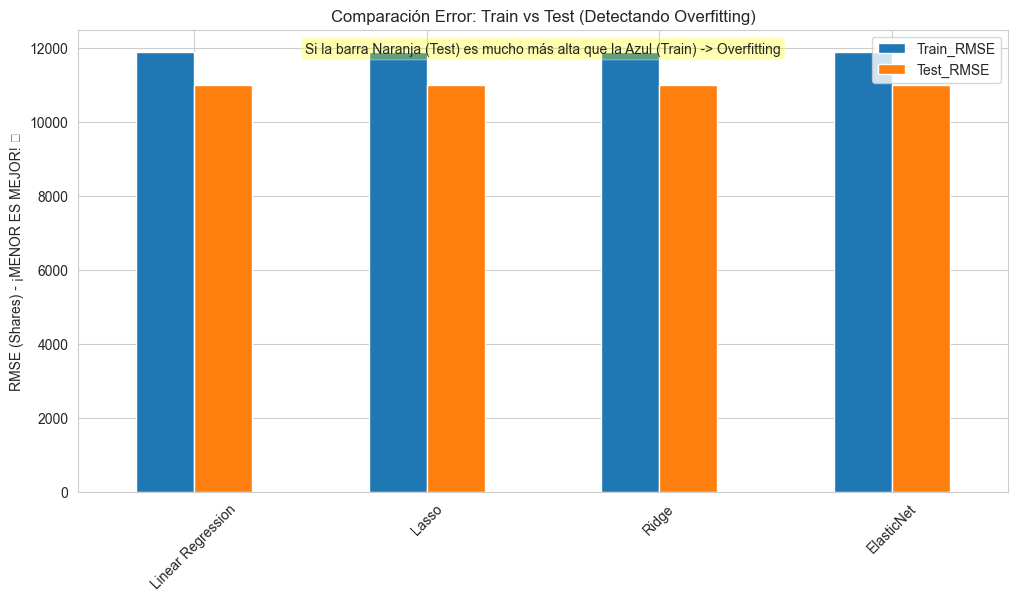

In [10]:
results_df = pd.DataFrame(results).T
print(results_df[['Train_RMSE', 'Test_RMSE', 'Train_R2', 'Test_R2']])

# Visualización: Train vs Test RMSE
# NOTA: Para RMSE, MENOR es MEJOR. 

ax = results_df[['Train_RMSE', 'Test_RMSE']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparación Error: Train vs Test (Detectando Overfitting)')
plt.ylabel('RMSE (Shares) - ¡MENOR ES MEJOR! ⬇')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

# Añadir anotación explicativa
plt.annotate('Si la barra Naranja (Test) es mucho más alta que la Azul (Train) -> Overfitting',
             xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.show()

### 2. Curva de Aprendizaje (Learning Curve): Diagnóstico de Underfitting/Overfitting
La curva de aprendizaje nos ayuda a visualizar si añadir más datos mejoraría el modelo o si estamos en el límite de la capacidad del modelo.

- **Underfitting**: Ambas curvas (Train/Test) convergen a un error ALTO.
- **Overfitting**: Existe una gran brecha (gap) entre la curva de Train (error bajo) y Test (error alto).
- **Buen Ajuste**: Ambas curvas convergen a un error BAJO con poca brecha.

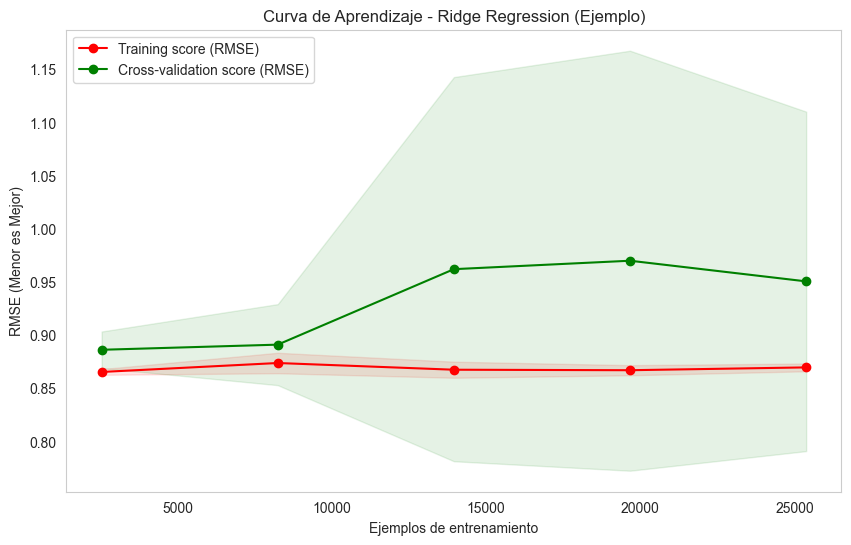

In [11]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Ejemplos de entrenamiento")
    plt.ylabel("Score (Neg MSE)") # Sklearn usa scores donde mayor es mejor, usaremos neg_mean_squared_error

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_root_mean_squared_error')

    # Convertir a RMSE positivo
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score (RMSE)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score (RMSE)")

    plt.legend(loc="best")
    return plt

# Usamos Ridge como modelo representativo para la curva
title = "Curva de Aprendizaje - Ridge Regression (Ejemplo)"
plot_learning_curve(Ridge(alpha=10.0), title, X_train_scaled, y_train, cv=5, n_jobs=-1)
plt.ylabel('RMSE (Menor es Mejor)')
plt.show()

### 3. Importancia de Características (Feature Importance)
Analizamos los coeficientes del modelo Lasso, ya que tiende a eliminar variables irrelevantes.

C:\Users\josea\AppData\Local\Temp\ipykernel_15668\3339945558.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='viridis')


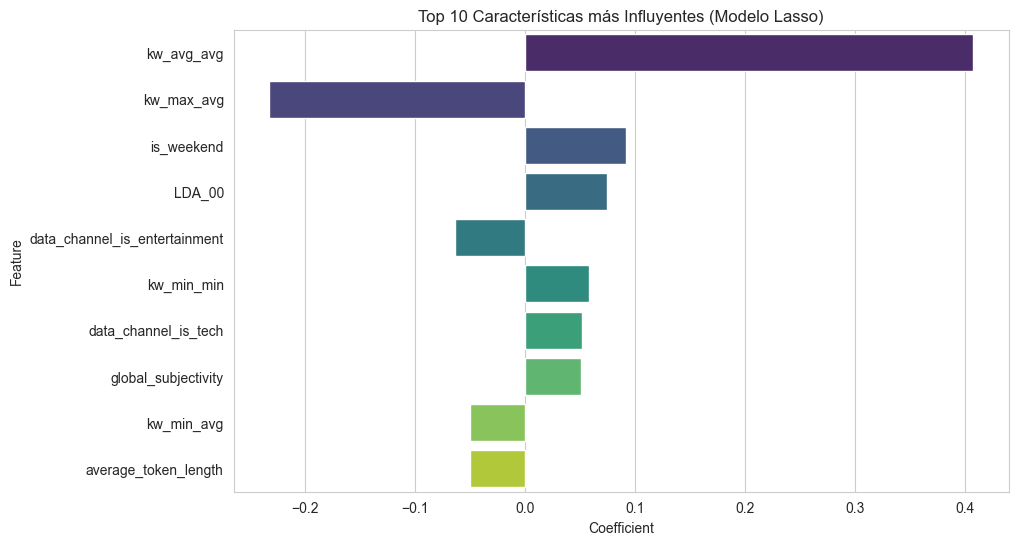

In [12]:
coefs = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
coefs['Abs_Coefficient'] = coefs['Coefficient'].abs()
top_features = coefs.sort_values(by='Abs_Coefficient', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Características más Influyentes (Modelo Lasso)')
plt.show()

### 4. Insights Adicionales: Análisis de Texto y Temas

Para profundizar más allá de los números, analizaremos:
1.  **Palabras Populares**: Extraídas de la URL del artículo.
2.  **Canales de Datos (Temas)**: ¿Qué categorías son más virales?

C:\Users\josea\AppData\Local\Temp\ipykernel_15668\1093126581.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=common_words_df, palette='magma')


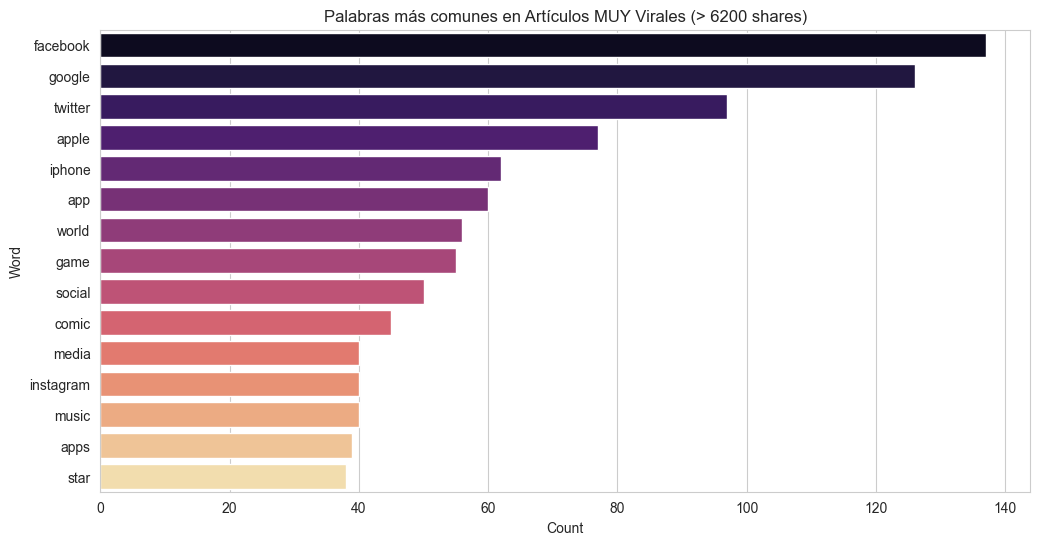

In [13]:
from collections import Counter
import re

# A. Análisis de Palabras en URLs (Proxy del Título)
def extract_words_from_url(url):
    # Formato típico: http://mashable.com/2013/01/07/amazon-instant-video-browser/
    # Extraemos la última parte (slug)
    if not isinstance(url, str):
        return []
        
    # Eliminar protocolo y dominio para seguridad
    parts = url.split('/')
    # Normalmente el slug es el último o penúltimo elemento no vacío
    # Las urls de mashable suelen tener fecha: /2013/01/07/SLUG/
    # Buscamos el segmento más largo que no sea fecha
    potential_slugs = [p for p in parts if len(p) > 3 and not p.isdigit() and 'mashable.com' not in p and 'http' not in p]
    
    if potential_slugs:
        slug = potential_slugs[-1] # Tomamos el último segmento significativo
        # Reemplazamos guiones por espacios y dividimos
        words = slug.replace('-', ' ').split()
        return words
    return []

# Filtramos artículos 'Virales' (Top 10% de shares para palabras más exclusivas)
top_10_shares = df_clean['shares'].quantile(0.90)
viral_articles = df_clean[df_clean['shares'] >= top_10_shares]

all_words = []
for url in viral_articles['url']:
    all_words.extend(extract_words_from_url(url))

# Filtramos palabras comunes (stopwords básicas en inglés)
stopwords = {'the', 'a', 'an', 'in', 'on', 'of', 'for', 'to', 'and', 'is', 'with', 'at', 'by', 'from', 'it', 'that', 'as', 'be', 'video', 'new', 'photos', 'one', 'how'}
filtered_words = [w.lower() for w in all_words if w.lower() not in stopwords and w.isalpha()]

word_counts = Counter(filtered_words)
common_words_df = pd.DataFrame(word_counts.most_common(15), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=common_words_df, palette='magma')
plt.title(f'Palabras más comunes en Artículos MUY Virales (> {int(top_10_shares)} shares)')
plt.show()

C:\Users\josea\AppData\Local\Temp\ipykernel_15668\3425090171.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Channel', y='Median Shares', data=channel_df, palette='Blues_d')


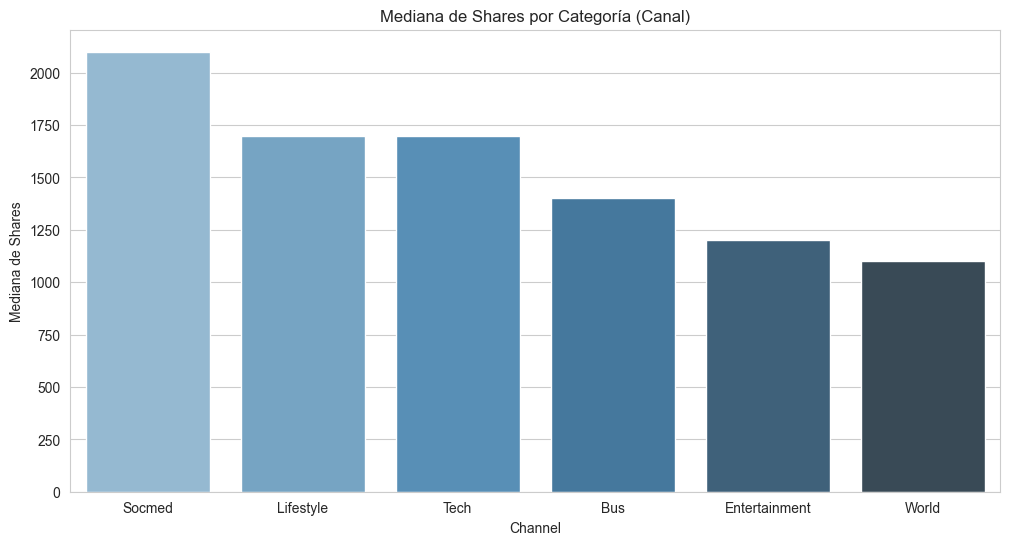

In [14]:
# B. Análisis por Canal (Topic)
# Las columnas son data_channel_is_*
channels = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 
            'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world']

channel_stats = []
for col in channels:
    channel_name = col.replace('data_channel_is_', '').capitalize()
    # Filtramos filas donde el canal es 1
    subset = df_clean[df_clean[col] == 1]
    if len(subset) > 0:
        mean_shares = subset['shares'].mean()
        median_shares = subset['shares'].median()
        count = len(subset)
        channel_stats.append({'Channel': channel_name, 'Mean Shares': mean_shares, 'Median Shares': median_shares, 'Count': count})

channel_df = pd.DataFrame(channel_stats).sort_values(by='Median Shares', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Channel', y='Median Shares', data=channel_df, palette='Blues_d')
plt.title('Mediana de Shares por Categoría (Canal)')
plt.ylabel('Mediana de Shares')
plt.show()

### 5. Conclusiones y Diagnóstico de Modelo

- **Underfitting vs Overfitting**: 
    - La **Curva de Aprendizaje** nos muestra la brecha entre Train y Validation. 
    - Si ambas curvas están cerca pero el error es alto, tendríamos **Underfitting** (necesitamos modelos más complejos o mejores features).
    - Si hay mucha distancia entre ellas, tendríamos **Overfitting** (necesitamos más datos o regularización fuerte).
- **Insights**: Palabras como **Google** y **Redes Sociales** dominan la viralidad.